# 07 PyTorch Experiment Tracking

Machine learning is very experimental.

In order to figure out which experiments are worth pursuing, that's where experiment tracking comes in, it helps you to figure out what doesn't work so you can figure out what does work.

In this notebook, we're going to see an example of programmatically tracking experiments.

In [26]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision 
from torchvision import datasets 
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import torchmetrics
import torchmetrics

# Import torchinfo
import torchinfo
from torchinfo import summary

# Import tensorboard
from torch.utils.tensorboard import SummaryWriter

# Import plotting libraries
import matplotlib.pyplot as plt

# Other imports
import requests
from pathlib import Path
import pandas as pd
import numpy as np
import random
import zipfile
import os
from PIL import Image
from timeit import default_timer as timer
from typing import Dict, List, Tuple

# Set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Check version
print(torch.__version__)
print(torchvision.__version__)
print(torchmetrics.__version__)
print(torchinfo.__version__)
print(device)

2.5.1
0.20.1
1.6.0
1.8.0
mps


In [4]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.mps.manual_seed(seed)

In [5]:
set_seeds()

## 1. Get data

Want to get pizza, steak, sushi images.

So we can run experiments building FoodVision Mini and see which model performs best.

In [9]:
def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination."""
    # Setup data path
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, create it.
    if image_path.is_dir():
        print(f"[INFO] {image_path} folder already exists. Skipping creating it.")
    else:
        print(f"[INFO] Creating {image_path} folder.")
        image_path.mkdir(parents=True, exist_ok=True)

    # Download data set
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
        request = requests.get(source)
        print("[INFO] Downloading {target_file} from {source}...")
        f.write(request.content)

    # Unzip file
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
        print(f"[INFO] Unzipping {target_file} data...")
        zip_ref.extractall(image_path)

    # Delete zip file
    if remove_source:
        os.remove(data_path / target_file)
    
    return image_path

In [10]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi folder already exists. Skipping creating it.
[INFO] Downloading {target_file} from {source}...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

### 2.1 Create DataLoaders with manual transforms
The goal with transforms is to ensure your custom data is formatted in a reproducible way as well as a way that will suit pretrained models.

In [11]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path /"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [13]:
# Setup up ImageNet normalization transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        normalize])

print(f"Manually created transforms: {manual_transforms}")

# Create DataLoaders
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x14c5fdf10>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

In [14]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms used to train a particular or obtain a particular set of weights)
automatic_transforms = weights.transforms()

# Create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=automatic_transforms,
                                                                               batch_size=32)

## 3. Getting a pretrained model, freeze the base layers and change the classifier head

In [15]:
# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [16]:
# Freeze all base layers by setting their requires_grad attribute to False
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [17]:
# Adjust the classifier head
set_seeds()
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))).to(device)

In [20]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [21]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 4. Train a single model and track results

In [22]:
# Define loss function optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

To track experiments, we're going to use TensorBoard: https://www.tensorflow.org/tensorboard/

And to interact with TensorBoard, we can use PyTorch's SummaryWriter - https://pytorch.org/docs/stable/tensorboard.html

Also see here: https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter

In [27]:
# Setup a SummaryWriter
writer = SummaryWriter()
writer

In [29]:
from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # See SummaryWriter documentation
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
        
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)
        
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))

    # Close the writer
    writer.close()
    ### End new ### 

    # Return the filled results at the end of the epochs
    return results

In [30]:
# Train model 
# Note: not using engine.train(), since we updated the train() function above
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

Epoch: 1 | train_loss: 1.0815 | train_acc: 0.4023 | test_loss: 0.8985 | test_acc: 0.5909
Epoch: 2 | train_loss: 0.9207 | train_acc: 0.6602 | test_loss: 0.7962 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.7824 | train_acc: 0.7578 | test_loss: 0.6821 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6884 | train_acc: 0.8359 | test_loss: 0.6788 | test_acc: 0.8352
Epoch: 5 | train_loss: 0.7105 | train_acc: 0.7109 | test_loss: 0.6903 | test_acc: 0.7027


In [31]:
results

{'train_loss': [1.0815253853797913,
  0.9206662774085999,
  0.7824286445975304,
  0.6883500218391418,
  0.710469413548708],
 'train_acc': [0.40234375, 0.66015625, 0.7578125, 0.8359375, 0.7109375],
 'test_loss': [0.8985207478205363,
  0.7961942752202352,
  0.6820742885271708,
  0.6788065632184347,
  0.6902880668640137],
 'test_acc': [0.5909090909090909,
  0.8456439393939394,
  0.8863636363636364,
  0.8352272727272728,
  0.7026515151515151]}

## 5. View our model's results with TensorBoard
There are a few ways to view TensorBoard results, see them here: https://www.learnpytorch.io/07_pytorch_experiment_tracking/#5-view-our-models-results-in-tensorboard

In [32]:
# Let's view our experiments from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

## 6. Create a function to prepare a `SummaryWriter()` instance
By default our `SummaryWriter()` class saves to `log_dir`.

How about if we wanted to save different experiments to different folders?

In essence, one experiment = one folder.

For example, we'd like to track:

* Experiment date/timestamp
* Experiment name
* Model name
* Extra - is there anything else that should be tracked?

Let's create a function to create a `SummaryWriter()` instance to take all of these things into account.

So ideally we end up tracking experiments to a directory:

`runs/YYYY-MM-DD/experiment_name/model_name/extra`

In [33]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
  """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory."""
  from datetime import datetime
  import os

  # Get timestamp of current date in reverse order
  timestamp = datetime.now().strftime("%Y-%m-%d") 

  if extra:
    # Create log directory path
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
  else:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
  print(f"[INFO] Created SummaryWriter saving to {log_dir}")
  return SummaryWriter(log_dir=log_dir)

In [34]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")
example_writer

[INFO] Created SummaryWriter saving to runs/2025-01-02/data_10_percent/effnetb0/5_epochs


### 6.1 Update the train() function to include a writer parameter

In [35]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        if writer: 
          # See SummaryWriter documentation
          writer.add_scalars(main_tag="Loss",
                              tag_scalar_dict={"train_loss": train_loss,
                                              "test_loss": test_loss},
                              global_step=epoch)
          
          writer.add_scalars(main_tag="Accuracy",
                              tag_scalar_dict={"train_acc": train_acc,
                                              "test_acc": test_acc},
                              global_step=epoch)
          
          writer.add_graph(model=model,
                            input_to_model=torch.randn(32, 3, 224, 224).to(device))

          # Close the writer
          writer.close()
        
        else:
          pass
    ### End new ### 

    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments
Challenge: Setup 2x modelling experiments with effnetb0, pizza, steak, sushi data and train one model for 5 epochs and another model for 10 epochs

7.1 What kind of experiments should you run?
The number of machine learning experiments you can run, is like the number of different models you can build... almost limitless.

However, you can't test everything...

So what should you test?

* Change the number of epochs
* Change the number of hidden layers/units
* Change the amount of data (right now we're using 10% of the Food101 dataset for pizza, steak, sushi)
* Change the learning rate
* Try different kinds of data augmentation
* Choose a different model architecture

This is why transfer learning is so powerful, because, it's a working model that you can apply to your own problem.

### 7.2 What experiments are we going to run?
We're going to turn three dials:

1. Model size - EffnetB0 vs EffnetB2 (in terms of number of parameters)
2. Dataset size - 10% of pizza, steak, sushi images vs 20% (generally more data = better results)
3. Training time - 5 epochs vs 10 epochs (generally longer training time = better results, up to a point)
To begin, we're still keeping things relatively small so that our experiments run quickly.

*Our goal*: a model that is well performing but still small enough to run on a mobile device or web browser, so FoodVision Mini can come to life.

If you had infinite compute + time, you should basically always choose the biggest model and biggest dataset you can. See: http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 7.3 Download different datasets
We want two datasets:

1. Pizza, steak, sushi 10% - https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
2. Pizza, steak, sushi 20% - https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip

They were created with: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb

In [36]:
# Download 10 percent and 20 percent datasets
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
     

[INFO] data/pizza_steak_sushi folder already exists. Skipping creating it.
[INFO] Downloading {target_file} from {source}...
[INFO] Unzipping pizza_steak_sushi.zip data...
[INFO] Creating data/pizza_steak_sushi_20_percent folder.
[INFO] Downloading {target_file} from {source}...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


### 7.4 Transform Datasets and Create DataLoaders
We'll to transform our data in a few ways:

1. Resize the images to (224, 224)
2. Make sure image tensor values are between [0, 1]
3. Normalize the images so they have the same data distribution as ImageNet

In [37]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup the test directory
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [38]:
# Setup ImageNet normalization levels
# See here: https://pytorch.org/vision/0.12/models.html 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Compose transforms into a pipleine
simple_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       normalize
])

In [39]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 10% test data: {len(test_dataloader)}")
print(f"Class names: {class_names}")

Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 20% train data: 15
Number of batches of size 32 in 10% test data: 3
Class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models
We want two functions:

1. Creates a torchvision.models.efficientnet_b0() feature extractor with a frozen backbone/base layers and a custom classifier head (EffNetB0).
2. Creates a torchvision.models.efficientnet_b2() feature extractor with a frozen backbone/base layers and a custom classifier head (EffNetB2).

In [40]:
# Create an EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" = best available
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /Users/pgrigorakis/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:03<00:00, 9.90MB/s]


In [41]:
summary(model=effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [42]:
effnetb2.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [43]:
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
  # Get the weights and setup a model
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)

  # Freeze the base model layers
  for param in model.features.parameters():
    param.requires_grad = False

  # Change the classifier head
  set_seeds()
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1280, out_features=OUT_FEATURES)
  ).to(device)

  # Give the model a name
  model.name = "effnetb0"
  print(f"[INFO] Created new {model.name} model...")
  return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
  # Get the weights and setup a model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights=weights).to(device)

  # Freeze the base model layers
  for param in model.features.parameters():
    param.requires_grad = False

  # Change the classifier head
  set_seeds()
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=OUT_FEATURES)
  ).to(device)

  # Give the model a name
  model.name = "effnetb2"
  print(f"[INFO] Created new {model.name} model...")
  return model

In [44]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [45]:
created_model_test_effnetb2 = create_effnetb2()
created_model_test_effnetb0 = create_effnetb0()

[INFO] Created new effnetb2 model...
[INFO] Created new effnetb0 model...


In [46]:
# Check out EffNetB2 feature extractor
summary(model=created_model_test_effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [47]:
# Check out EffNetB0 feature extractor model
summary(model=created_model_test_effnetb0,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [48]:
created_model_test_effnetb2.to(device)
created_model_test_effnetb0.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 7.6 Create experiments and set up training code

In [49]:
# Create epoch list
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"] 

# Create a DataLoaders dictionary
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [51]:
%%time
from going_modular.utils import save_model

# Set seeds
set_seeds(seed=42)

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
  # Loop through the epochs
  for epochs in num_epochs:
    # Loop through each model name and create a new model instance
    for model_name in models:

      # Print out info
      experiment_number += 1
      print(f"[INFO] Experiment number: {experiment_number}")
      print(f"[INFO] Model: {model_name}")
      print(f"[INFO] DataLoader: {dataloader_name}")
      print(f"[INFO] Number of epochs: {epochs}")

      # Select and create the model
      if model_name == "effnetb0":
        model = create_effnetb0()
      else:
        model = create_effnetb2()
      
      # Create a new loss and optimizer for every model
      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

      # Train target model with target dataloader and track experiments 
      # Note: using train() rather than engine.train()
      train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device,
            writer=create_writer(experiment_name=dataloader_name,
                                 model_name=model_name,
                                 extra=f"{epochs}_epochs"))
      
      # Save the model to file so we can import it later if need be
      save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
      save_model(model=model,
                 target_dir="models",
                 model_name=save_filepath)
      print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2025-01-02/data_10_percent/effnetb0/5_epochs
Epoch: 1 | train_loss: 1.0624 | train_acc: 0.4648 | test_loss: 0.9344 | test_acc: 0.4574
Epoch: 2 | train_loss: 0.9364 | train_acc: 0.5781 | test_loss: 0.8267 | test_acc: 0.6108
Epoch: 3 | train_loss: 0.8002 | train_acc: 0.6914 | test_loss: 0.7180 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7128 | train_acc: 0.7773 | test_loss: 0.6182 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6097 | train_acc: 0.8906 | test_loss: 0.5751 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to run

## 8. View experiments in TensorBoard
We've experiment, experiment, experiment!

Now let's visualize, visualize, visualize!

In [52]:
# Let's view our experiments within TensorBoard from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 49855), started 0:17:44 ago. (Use '!kill 49855' to kill it.)

The best performing model was:

* Model: EffNetB2
* Dataset: Pizza, steak, sushi 20%
* Epochs: 10

And the overall trend of all the results was that more data, bigger model and longer training time generally led to better results.

## 9. Load in the best model and mkae predictions with it
This is our best model filepath: `models/07_effnetb2_data_20_percent_10_epochs.pth`

In [54]:
# Setup best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load in the saved state_dict())
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model...


/var/folders/yy/j3y_mcxx609fklcnx_s5nrhr0000gn/T/ipykernel_91757/4104911100.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_mo

<All keys matched successfully>

In [55]:
# Get the model size in bytes then convert it to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


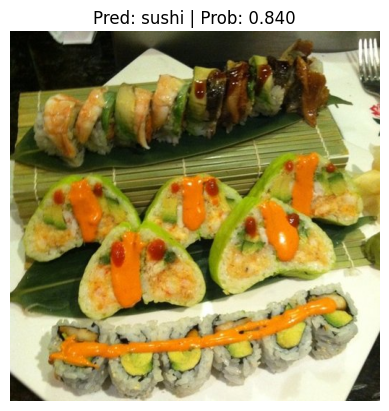

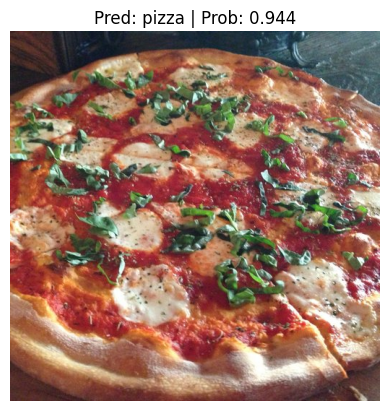

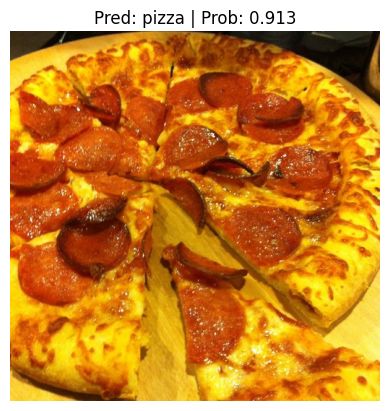

In [57]:
# Import function to make prediction on images and plot them
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=best_model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

### 9.1 Predict on a custom image with the best model

In [58]:
# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


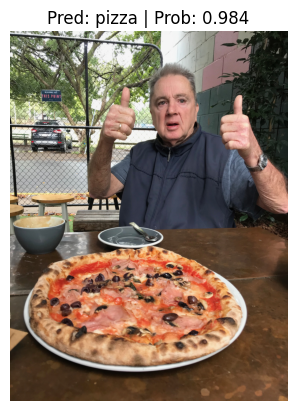

In [59]:
# Predict on our own custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)